# SDE - Heston model

## Contents
   - [Correlated Normal random variables](#sec1)
   - [Heston model](#sec2)
      - [Distribution of log-returns](#sec2.1)
   - [Characteristic function](#sec3)
      - [Option pricing](#sec3.1)

In [1]:
import numpy as np
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
import scipy.special as scps
from statsmodels.graphics.gofplots import qqplot
from scipy.linalg import cholesky
from functools import partial
from FMNM.probabilities import Heston_pdf, Q1, Q2
from FMNM.cython.heston import Heston_paths_log, Heston_paths
from scipy.optimize import minimize

from IPython.display import display
import sympy

sympy.init_printing()


def display_matrix(m):
    display(sympy.Matrix(m))

<a id='sec1'></a>
# Correlated Normal random variables

In order to generate $n$ correlated Gaussian distributed random variables

$$ Y \sim \mathcal{N}(\mu, \Sigma) $$

where $Y=(𝑌_1,...,𝑌_n)$ is the vector to simulate, $\mu = (\mu_1,...,\mu_n)$ the vector of means and $\Sigma$
the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix),

1) we first need to simulate a vector of uncorrelated standard Normal random variables, $Z$

2) then find a square root of $\Sigma$, i.e. a matrix $C$ such that $C C^T = \Sigma$.

The vector is given by $$Y = \mu + C Z .$$ 

A popular choice to calculate $C$ is the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition).

#### Example:

Let us consider the following 2-dimensional covariance matrix:

$$ \Sigma = \left(
\begin{array}{cc}
1    & \rho   \\
\rho & 1      \\
\end{array}
\right) $$

where for simplicity I chose $Var[Y_1]=Var[Y_2]=1$, such that $\Sigma$ corresponds to the [correlation matrix](https://en.wikipedia.org/wiki/Correlation_and_dependence#Correlation_matrices).  I also set $\mu = 0$.

In python we can use the built in function `scipy.stats.multivariate_normal` as follows:

COV: 


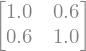

correlation matrix: 


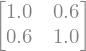

In [2]:
SIZE = 1000000
rho = 0.6

MU = np.array([0, 0])
COV = np.array([[1, rho], [rho, 1]])
print("COV: ")
display_matrix(COV)

Y = ss.multivariate_normal.rvs(mean=MU, cov=COV, size=SIZE)

print("correlation matrix: ")
display_matrix(np.corrcoef(Y.T).round(2))

If we want to use the algorithm proposed above, we have to find the matrix C.

In two dimensions it has the simple form:

$$ C = \left(
\begin{array}{cc}
1    & 0   \\
\rho & \sqrt{1-\rho^2}  \\
\end{array}
\right). $$

By a simple matrix multiplication we can verify that:

$$ \left(
\begin{array}{cc}
1    & 0   \\
\rho & \sqrt{1-\rho^2}  \\
\end{array}
\right) \cdot 
\left(
\begin{array}{cc}
1    & \rho  \\
0 & \sqrt{1-\rho^2}  \\
\end{array}
\right)
= \left(
\begin{array}{cc}
1    & \rho   \\
\rho & 1      \\
\end{array}
\right)
$$

Therefore, in 2 dimensions there is no need to use the Cholesky decomposition. We simply have:

$$ \begin{cases} Y_1 = Z_1 \\ Y_2 = \rho Z_1 + \sqrt{1-\rho^2} Z_2  \end{cases} $$


correlation matrix: 


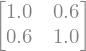

In [3]:
Y_1 = np.random.normal(loc=0, scale=1, size=SIZE)
Y_2 = rho * Y_1 + np.sqrt(1 - rho**2) * np.random.normal(loc=0, scale=1, size=SIZE)
print("correlation matrix: ")
display_matrix(np.corrcoef(Y_1, Y_2).round(2))

For higher dimensional problems, the function `scipy.linalg.cholesky` [doc](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.linalg.cholesky.html) can help:

Cholesky: 


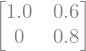

Correlation matrix: 


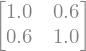

In [4]:
print("Cholesky: ")
display_matrix(cholesky(COV))
print("Correlation matrix: ")
display_matrix(cholesky(COV, lower=True) @ cholesky(COV))

<a id='sec2'></a>
# Heston model

The [Heston process](https://en.wikipedia.org/wiki/Heston_model) is described by the SDE: 

$$ \begin{cases}
dS_t = \mu S_t dt + \sqrt{v_t} S_t dW^1_t \\
dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW^2_t 
\end{cases}$$

The stock price follows a "geometric Brownian motion" with a stochastic volatility. The square of the volatility (the variance) follows a CIR process.     
Have a look at the notebook **1.2** for more information on the CIR process.

The parameters are:
- $\mu$ drift of the stock process
- $\kappa$ mean reversion coefficient of the variance process
- $\theta$ long term mean of the variance process 
- $\sigma$  volatility coefficient of the variance process
- $\rho$ correlation between $W^1$ and $W^2$ i.e.
$$ dW^1_t dW^2_t = \rho dt $$

We will also require that $2\kappa \theta > \sigma^2$ (Feller condition).

##### Path generation

The Heston process can be discretized using the Euler-Maruyama method proposed in the notebook **2.1**.

In the next cell I present the algorithm that produces sample paths of the Heston process. In this example, I prefer to use the log-variables $X_t = \log(S_t)$ and $Y_t = \log(v_t)$ in order to avoid negative values for the process $\{v_t\}_{t\geq 0}$.    

$$ \begin{cases}
dX_t = \biggl( \mu - \frac{1}{2} e^{Y_t} \biggr) dt + e^{Y_t/2} dW^1_t \\
dY_t = e^{-Y_t} \biggl[ \kappa (\theta - e^{Y_t}) - \frac{1}{2}\sigma^2 \biggr] dt + \sigma e^{-Y_t/2} dW^2_t 
\end{cases}$$

This is an arbitrary choice! 

**Comment:**         
From a theoretical point of view, using log-variables is the best choice, because it avoids negative values without any tweak of the original process.     
From the practical point of view, it is better not to use log-variables!    
The reason is that the algorithm can produce NaNs or overflows when the time steps are not small enough (e.g. for $N<20000$). This happens quite frequently. 

In [5]:
%%time
np.random.seed(seed=42)

N = 1000000  # time steps
paths = 3  # number of paths
T = 1
T_vec, dt = np.linspace(0, T, N, retstep=True)
dt_sq = np.sqrt(dt)

S0 = 100  # spot price
X0 = np.log(S0)  # log price
v0 = 0.04  # spot variance
Y0 = np.log(v0)  # log-variance

mu = 0.1  # drift
rho = -0.2  # correlation coefficient
kappa = 2  # mean reversion coefficient
theta = 0.04  # long-term variance
sigma = 0.3  # Vol of Vol - Volatility of instantaneous variance
std_asy = np.sqrt(theta * sigma**2 / (2 * kappa))  # asymptotic standard deviation for the CIR process
assert 2 * kappa * theta > sigma**2  # Feller condition

# Generate random Brownian Motion
MU = np.array([0, 0])
COV = np.matrix([[1, rho], [rho, 1]])
W = ss.multivariate_normal.rvs(mean=MU, cov=COV, size=(N - 1, paths))
W_S = W[:, :, 0]  # Stock Brownian motion:     W_1
W_v = W[:, :, 1]  # Variance Brownian motion:  W_2

# Initialize vectors
Y = np.zeros((N, paths))
Y[0, :] = Y0
X = np.zeros((N, paths))
X[0, :] = X0
v = np.zeros(N)

# Generate paths
for t in range(0, N - 1):
    v = np.exp(Y[t, :])  # variance
    v_sq = np.sqrt(v)  # square root of variance

    Y[t + 1, :] = (
        Y[t, :] + (1 / v) * (kappa * (theta - v) - 0.5 * sigma**2) * dt + sigma * (1 / v_sq) * dt_sq * W_v[t, :]
    )
    X[t + 1, :] = X[t, :] + (mu - 0.5 * v) * dt + v_sq * dt_sq * W_S[t, :]

CPU times: user 9.93 s, sys: 32.8 ms, total: 9.96 s
Wall time: 10.1 s


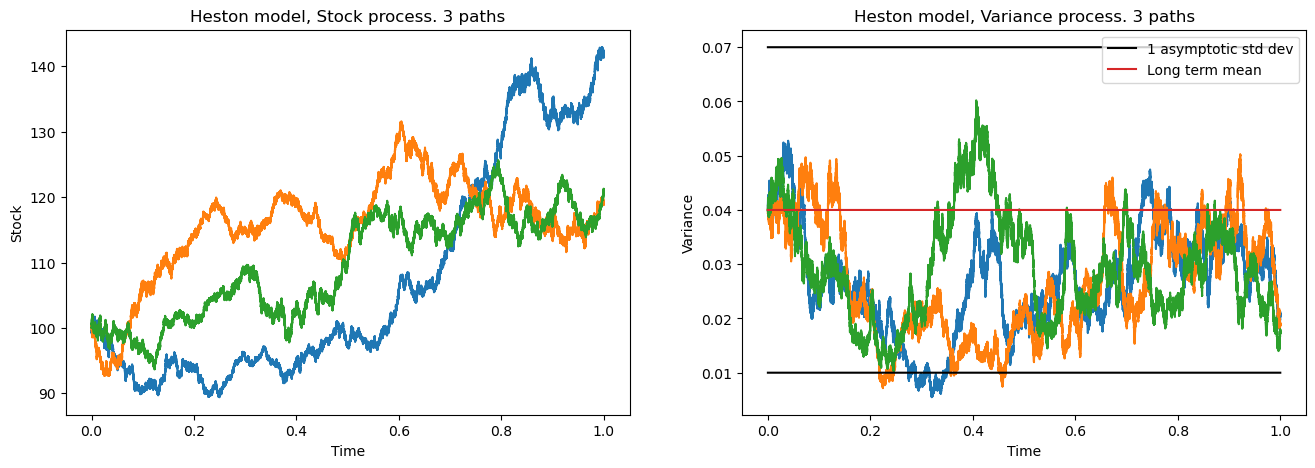

In [6]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(T_vec, np.exp(X))
ax1.set_title("Heston model, Stock process. 3 paths")
ax1.set_xlabel("Time")
ax1.set_ylabel("Stock")
ax2.plot(T_vec, np.exp(Y))
ax2.set_title("Heston model, Variance process. 3 paths")
ax2.set_xlabel("Time")
ax2.set_ylabel("Variance")
ax2.plot(T_vec, (theta + std_asy) * np.ones_like(T_vec), label="1 asymptotic std dev", color="black")
ax2.plot(T_vec, (theta - std_asy) * np.ones_like(T_vec), color="black")
ax2.plot(T_vec, theta * np.ones_like(T_vec), label="Long term mean")
ax2.legend(loc="upper right")
plt.show()

<a id='sec2.1'></a>
# Distribution of log-returns

The python code presented above is very slow when we want to generate a big number of paths.    
For this reason I implemented it in Cython. 

For a short introduction to Cython, have a look at the notebook **A2**.     
This is the [Cython code](./functions/cython/cython_Heston.pyx), that makes also use of some C functions.


##### CYTHON implementation

1) The function `Heston_paths_log` contains the code presented above, but translated in Cython.      
   The code returns only the "good" paths. It means that if there are overflows, they are ignored.     
   Since this method returns a "random" number of paths, I will prefer to use the next method.

2) The function `Heston_paths` implements the discretization of the original process $(S_t,v_t)_{t\geq 0}$.
   The CIR process is discretized using the method (4) presented in the notebook **1.2** i.e. by taking the absolute value of the variance at each time step.



I import the following cython functions:
```python
from FMNM.cython.cython_Heston import Heston_paths_log, Heston_paths
```

Let us re-define the parameters of the process, together with the parameters of the CIR density.

In [7]:
mu = 0.1  # drift
rho = -0.9  # correlation coefficient
kappa = 2  # mean reversion coefficient
theta = 0.04  # long-term mean of the variance
sigma = 0.3  # (Vol of Vol) - Volatility of instantaneous variance
T = 1  # Terminal time
v0 = 0.04  # spot variance
S0 = 100  # spot stock price

c = 2 * kappa / ((1 - np.exp(-kappa * T)) * sigma**2)
df = 4 * kappa * theta / sigma**2  # degrees of freedom
nc = 2 * c * v0 * np.exp(-kappa * T)  # non-centrality parameter

The next cell just wants to check if there are overflows for small value of $N$ (big time steps).

In [8]:
_, _ = Heston_paths_log(N=500, paths=20000, T=T, S0=S0, v0=v0, mu=mu, rho=rho, kappa=kappa, theta=theta, sigma=sigma)

WARNING.  8  paths have been removed because of the overflow.
SOLUTION: Use a bigger value N.


OK.... now we are going to use the other function:

In [9]:
%%time
S, V = Heston_paths(N=20000, paths=20000, T=T, S0=S0, v0=v0, mu=mu, rho=rho, kappa=kappa, theta=theta, sigma=sigma)

CPU times: user 16.4 s, sys: 53.4 ms, total: 16.4 s
Wall time: 16.6 s


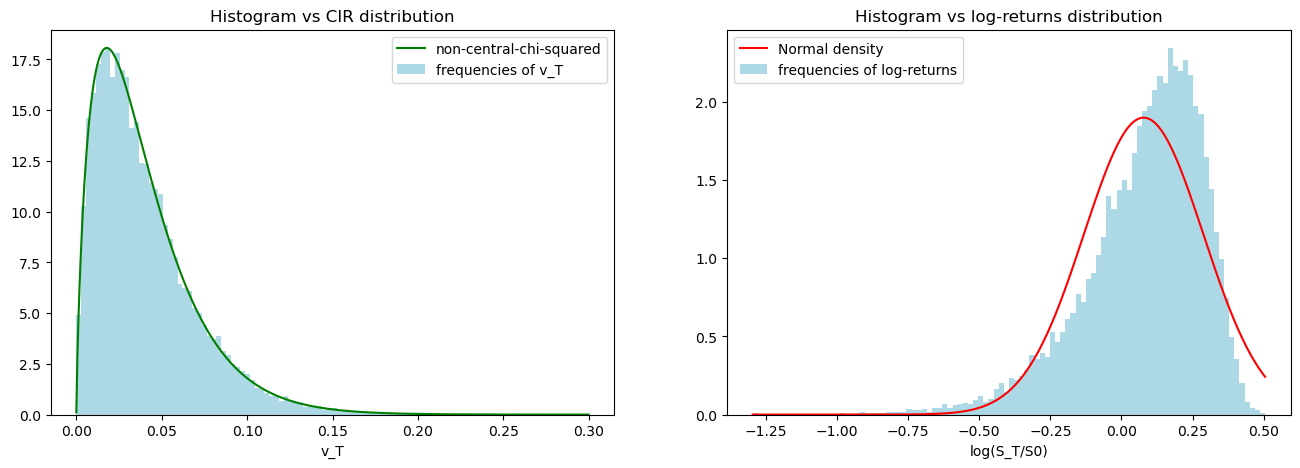

In [10]:
log_R = np.log(S / S0)
x = np.linspace(log_R.min(), log_R.max(), 500)
y = np.linspace(0.00001, 0.3, 500)

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(y, ss.ncx2.pdf(y, df, nc, scale=1 / (2 * c)), color="green", label="non-central-chi-squared")
ax1.hist(V, density=True, bins=100, facecolor="LightBlue", label="frequencies of v_T")
ax1.legend()
ax1.set_title("Histogram vs CIR distribution")
ax1.set_xlabel("v_T")

ax2.plot(x, ss.norm.pdf(x, log_R.mean(), log_R.std(ddof=0)), color="r", label="Normal density")
ax2.hist(log_R, density=True, bins=100, facecolor="LightBlue", label="frequencies of log-returns")
ax2.legend()
ax2.set_title("Histogram vs log-returns distribution")
ax2.set_xlabel("log(S_T/S0)")
plt.show()

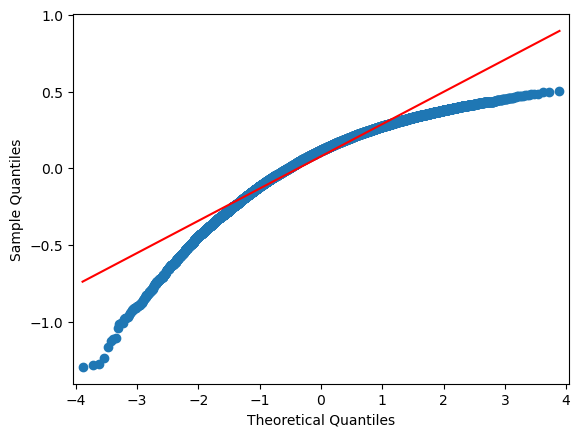

In [11]:
qqplot(log_R, line="s")
plt.show()

**The distribution of the log-returns is far from being normal!!**    
(as you can see also from the q-q plot)

This is a good property, because we can describe better the features of the empirical distributions obtained from market data!

You can play with the correlation parameter $\rho$ in order to obtain different skewness values.

- For negative $\rho$, we generate a log-return distribution with negative skewness.
- For positive $\rho$, we generate a log-return distribution with positive skewness.

In [12]:
%%time
S2, _ = Heston_paths(N=20000, paths=20000, T=T, S0=S0, v0=v0, mu=mu, rho=0.9, kappa=kappa, theta=theta, sigma=sigma)
log_R2 = np.log(S2 / S0)

CPU times: user 16.4 s, sys: 72.9 ms, total: 16.5 s
Wall time: 16.7 s


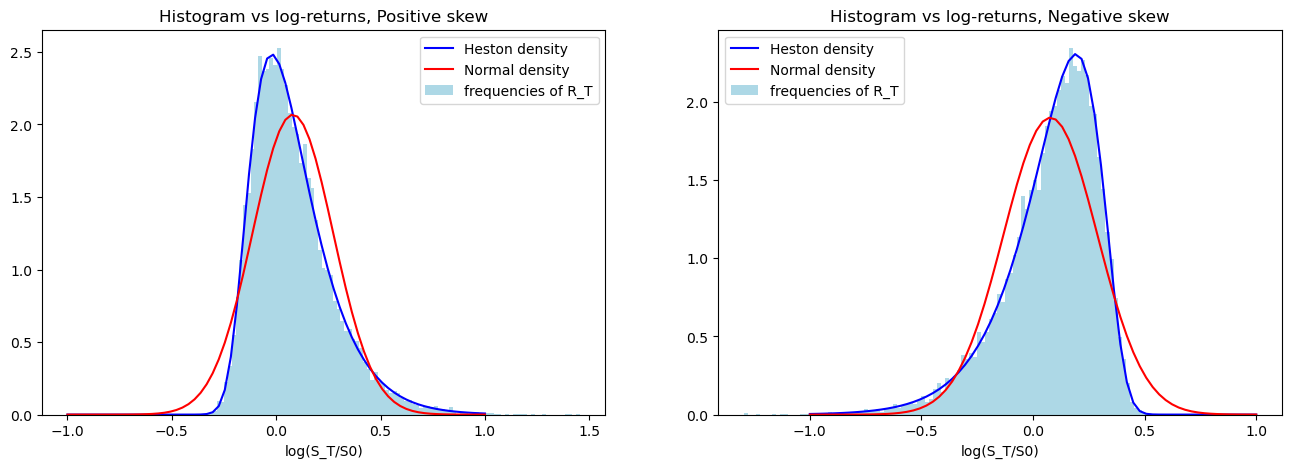

In [13]:
x = np.linspace(-1, 1, 70)

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(
    x,
    [Heston_pdf(i, t=T, v0=v0, mu=mu, theta=theta, sigma=sigma, kappa=kappa, rho=0.9) for i in x],
    color="blue",
    label="Heston density",
)
ax1.plot(x, ss.norm.pdf(x, log_R2.mean(), log_R2.std(ddof=0)), color="r", label="Normal density")
ax1.hist(log_R2, density=True, bins=100, facecolor="LightBlue", label="frequencies of R_T")
ax1.legend()
ax1.set_title("Histogram vs log-returns, Positive skew")
ax1.set_xlabel("log(S_T/S0)")

ax2.plot(
    x,
    [Heston_pdf(i, t=T, v0=v0, mu=mu, theta=theta, sigma=sigma, kappa=kappa, rho=-0.9) for i in x],
    color="blue",
    label="Heston density",
)
ax2.plot(x, ss.norm.pdf(x, log_R.mean(), log_R.std(ddof=0)), color="r", label="Normal density")
ax2.hist(log_R, density=True, bins=100, facecolor="LightBlue", label="frequencies of R_T")
ax2.legend(loc="upper left")
ax2.set_title("Histogram vs log-returns, Negative skew")
ax2.set_xlabel("log(S_T/S0)")
plt.show()

In [14]:
print("The skewness for rho= -0.9 is: ", ss.skew(log_R))
print("The skewness for rho= +0.9 is: ", ss.skew(log_R2))

The skewness for rho= -0.9 is:  -1.1550880187314136
The skewness for rho= +0.9 is:  1.1820448066432543


In the pictures above we can see the difference between the Normal distribution and the Heston distribution!

I used the function `Heston_pdf`, which implements the Fourier inversion of the Heston characteristic function using the Gil-Pelaez formula.     

For more information on Fourier inversion see the notebook **1.3**. 

<a id='sec3'></a>
# Characteristic function

The characteristic function (CF) for the Heston model was presented for the first time in the original paper of Heston (1993) [1].    

The Heston CF is very useful for the computation of option prices. All the other methods, such as Monte Carlo or PDE, are quite slow, while Fourier inversion (as we have seen in the notebook **1.3**) is super fast!

##### Issue with the Heston CF

The Heston CF works well for short time $T$.    
However, when the time increases this CF exhibits discontinuities due to the multivalued complex functions (the complex square root and the complex logarithm need to have a specified [Principal brach](https://en.wikipedia.org/wiki/Principal_branch)).
A consequence is that the numerical integration becomes unstable.

In the important articles [2] and [3], different (but equivalent) forms of the Heston CF are presented. These CFs consider different [Riemann surfaces](https://en.wikipedia.org/wiki/Riemann_surface) and resolve the problem.

In the following I will show how the CF proposed by Schoutens (in [2]) performs better than the Heston CF.     
In these notebooks, all the functions that consider the Heston CF are implemented using the CF `cf_Heston_good` proposed by Schoutens.

In [15]:
r = 0.05  # drift
rho = -0.8  # correlation coefficient
kappa = 3  # mean reversion coefficient
theta = 0.1  # long-term mean of the variance
sigma = 0.25  # (Vol of Vol) - Volatility of instantaneous variance
T = 15  # Terminal time
K = 100  # Stike
v0 = 0.08  # spot variance
S0 = 100  # spot stock price
k = np.log(K / S0)  # log moneyness

In [16]:
def cf_Heston(u, t, v0, mu, kappa, theta, sigma, rho):
    """
    Heston characteristic function as proposed in the original paper of Heston (1993)
    """
    xi = kappa - sigma * rho * u * 1j
    d = np.sqrt(xi**2 + sigma**2 * (u**2 + 1j * u))
    g1 = (xi + d) / (xi - d)
    cf = np.exp(
        1j * u * mu * t
        + (kappa * theta) / (sigma**2) * ((xi + d) * t - 2 * np.log((1 - g1 * np.exp(d * t)) / (1 - g1)))
        + (v0 / sigma**2) * (xi + d) * (1 - np.exp(d * t)) / (1 - g1 * np.exp(d * t))
    )
    return cf

In [17]:
def cf_Heston_good(u, t, v0, mu, kappa, theta, sigma, rho):
    """
    Heston characteristic function as proposed by Schoutens (2004)
    """
    xi = kappa - sigma * rho * u * 1j
    d = np.sqrt(xi**2 + sigma**2 * (u**2 + 1j * u))
    g1 = (xi + d) / (xi - d)
    g2 = 1 / g1
    cf = np.exp(
        1j * u * mu * t
        + (kappa * theta) / (sigma**2) * ((xi - d) * t - 2 * np.log((1 - g2 * np.exp(-d * t)) / (1 - g2)))
        + (v0 / sigma**2) * (xi - d) * (1 - np.exp(-d * t)) / (1 - g2 * np.exp(-d * t))
    )
    return cf

In [18]:
cf_H_b = partial(cf_Heston, t=T, v0=v0, mu=r, theta=theta, sigma=sigma, kappa=kappa, rho=rho)
cf_H_b_good = partial(cf_Heston_good, t=T, v0=v0, mu=r, theta=theta, sigma=sigma, kappa=kappa, rho=rho)

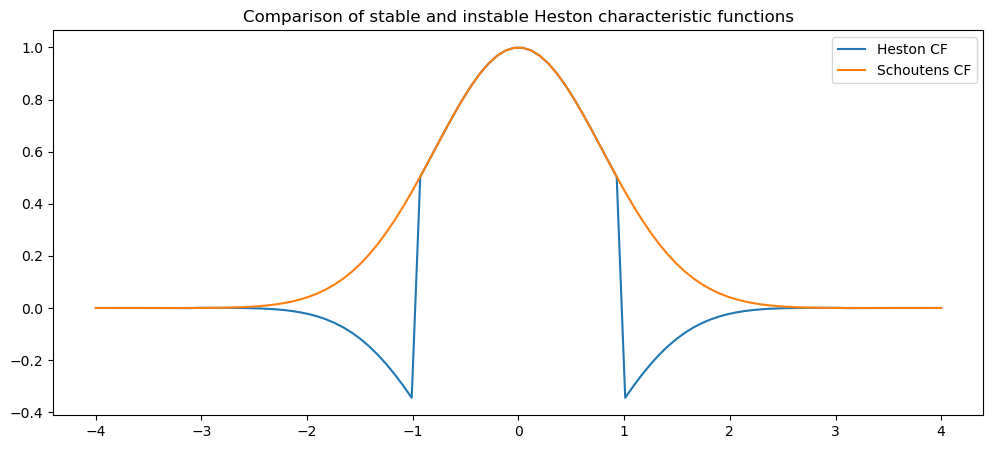

In [19]:
u = np.linspace(-4, 4, 100)

plt.figure(figsize=(12, 5))
plt.plot(u, np.real(cf_H_b(u)), label="Heston CF")
plt.plot(u, np.real(cf_H_b_good(u)), label="Schoutens CF")
plt.title("Comparison of stable and instable Heston characteristic functions")
plt.legend()
plt.show()

<a id='sec3.1'></a>
## Option pricing

We can compare the values of an European call option computed with the following two pricing methods: 

(as usual we consider the parameters defined above as the *risk neutral* parameters)

##### Monte Carlo

In [20]:
%%time
S, v = Heston_paths(N=20000, paths=20000, T=T, S0=S0, v0=v0, mu=r, rho=rho, kappa=kappa, theta=theta, sigma=sigma)
DiscountedPayoff = np.exp(-r * T) * np.maximum(S - K, 0)
V = np.mean(DiscountedPayoff)
std_err = ss.sem(DiscountedPayoff)
print("Heston Monte Carlo call price: ", V)
print("With standard error: ", std_err)
print("-----------------------------------")

Heston Monte Carlo call price:  64.8311510602247
With standard error:  1.1100688417854097
-----------------------------------
CPU times: user 16.4 s, sys: 668 ms, total: 17 s
Wall time: 17.3 s


##### Fourier inversion

In [21]:
%%time
limit_max = 1000  # right limit in the integration
call = S0 * Q1(k, cf_H_b_good, limit_max) - K * np.exp(-r * T) * Q2(k, cf_H_b_good, limit_max)
print("Heston Fourier inversion call price: ", call)
print("-----------------------------------")

Heston Fourier inversion call price:  65.27786862734644
-----------------------------------
CPU times: user 5.64 ms, sys: 174 µs, total: 5.81 ms
Wall time: 6.57 ms


## References

[1] Heston, S. L. (1993). "A closed-form solution for options with stochastic volatility and applications to bond and currency options". Review of Financial Studies

[2] Schoutens, W., Simons, E., & Tistaert, J. (2004). "A perfect calibration! Now what?". Wilmott Magazine
[link](https://perswww.kuleuven.be/~u0009713/ScSiTi03.pdf)

[3] Yiran Cui, Sebastian del Baño Rollin, Guido Germano, (2017), "Full and fast calibration of the Heston stochastic volatility model" European Journal of operational research. [link](http://www0.cs.ucl.ac.uk/staff/g.germano/papers/EurJOperRes_2017.pdf)